In [213]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
#import folium
from mpl_toolkits.basemap import Basemap
import plotly.express as px
import plotly.graph_objects as go

## 1. Загрузка данных

In [342]:
# Открытие CSV файла
df = pd.read_csv('Electric_cars_data.csv')
print(df.shape)
df.head()

(186879, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WBY8P6C58K,King,Seattle,WA,98115.0,2019,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,153,0,43.0,259254397,POINT (-122.3008235 47.6862671),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
1,5YJSA1DN4D,Kitsap,Bremerton,WA,98312.0,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,35.0,127420940,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,5.303508e+10
2,5YJSA1E26J,King,Kent,WA,98042.0,2018,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,249,0,47.0,170287183,POINT (-122.1145138 47.3581107),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
3,WBY2Z2C54E,King,Bellevue,WA,98004.0,2014,BMW,I8,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,41.0,205545868,POINT (-122.202397 47.619252),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
4,5YJXCDE23J,King,Bellevue,WA,98004.0,2018,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,41.0,237977386,POINT (-122.202397 47.619252),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10


## 2. Data Cleaning

### 2.1 Проверка данных на дубликаты

In [343]:
df[df.duplicated()]
#Дубликатов нет

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract


### 2.2 Проверка данных на пропуски

In [344]:
print("Информация о выборке:\n ")
df.info(null_counts=True)

Информация о выборке:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186879 entries, 0 to 186878
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         186879 non-null  object 
 1   County                                             186876 non-null  object 
 2   City                                               186876 non-null  object 
 3   State                                              186879 non-null  object 
 4   Postal Code                                        186876 non-null  float64
 5   Model Year                                         186879 non-null  int64  
 6   Make                                               186879 non-null  object 
 7   Model                                              186879 non-null  object 
 8   Electric Vehicle Type                             

C:\Users\Denis\AppData\Local\Temp\ipykernel_15516\3110607798.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True)


In [345]:
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values()
print("Процент пропущенных значений:\n ")
missing_values

Процент пропущенных значений:
 


VIN (1-10)                                           0.000000
DOL Vehicle ID                                       0.000000
Base MSRP                                            0.000000
Electric Range                                       0.000000
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0.000000
Model                                                0.000000
Electric Vehicle Type                                0.000000
Model Year                                           0.000000
State                                                0.000000
Make                                                 0.000000
Electric Utility                                     0.001605
Postal Code                                          0.001605
City                                                 0.001605
County                                               0.001605
2020 Census Tract                                    0.001605
Vehicle Location                                     0.004281
Legislat

In [346]:
# Так как пустые значения составляеют максимум 0.2% то мы их просто удаляем
df = df.dropna()

missing_values = ((df.isna().sum() / len(df)) * 100).sort_values()
print("Процент пропущенных значений:\n ")
missing_values

Процент пропущенных значений:
 


VIN (1-10)                                           0.0
Vehicle Location                                     0.0
DOL Vehicle ID                                       0.0
Legislative District                                 0.0
Base MSRP                                            0.0
Electric Range                                       0.0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0.0
Electric Utility                                     0.0
Electric Vehicle Type                                0.0
Make                                                 0.0
Model Year                                           0.0
Postal Code                                          0.0
State                                                0.0
City                                                 0.0
County                                               0.0
Model                                                0.0
2020 Census Tract                                    0.0
dtype: float64

In [347]:
# Заменяем тип данных столбца Legislative District на целочисленный
df['Legislative District'] = df['Legislative District'].astype(int)

### 2.3 Формирование новых прзнаков и обработка существующих признаков

In [348]:
# Извлекаем координаты широты и долготы
df['Latitude'] = df['Vehicle Location'].apply(lambda x: float(x.split()[1][1:]))  
df['Longitude'] = df['Vehicle Location'].apply(lambda x: float(x.split()[2][:-1]))  

# Удаляем исходный столбец Vehicle Location
df.drop(columns=['Vehicle Location'], inplace=True)


In [349]:
# Функция для замены значений в столбце 'Electric Vehicle Type'
def replace_ev_type(row):
    if 'BEV' in row['Electric Vehicle Type']:
        return 'BEV'
    elif 'PHEV' in row['Electric Vehicle Type']:
        return 'PHEV'
    else:
        return row['Electric Vehicle Type']

# Применение функции к столбцу 'Electric Vehicle Type'
df['Electric Vehicle Type'] = df.apply(replace_ev_type, axis=1)

In [350]:
# Функция для замены значений в столбце 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'
def replace_CAFV(row):
    if 'Clean Alternative Fuel Vehicle Eligible' in row['Clean Alternative Fuel Vehicle (CAFV) Eligibility']:
        return 'yes'
    elif 'Not eligible due to low battery range' in row['Clean Alternative Fuel Vehicle (CAFV) Eligibility']:
        return 'no'
    else:
        return 'unknown'

# Применение функции к столбцу 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'
df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = df.apply(replace_CAFV, axis=1)

In [351]:
df["VIN (1-10)"].value_counts()

7SAYGDEE6P    1236
7SAYGDEE7P    1227
7SAYGDEE5P    1192
7SAYGDEE8P    1190
7SAYGDEEXP    1189
              ... 
1C4RJYE63R       1
WP0BC2Y19P       1
WA1VABGE4M       1
WA12ABGE5L       1
WBA7J2C36H       1
Name: VIN (1-10), Length: 11237, dtype: int64

In [352]:
df["DOL Vehicle ID"].value_counts()

259254397    1
256299326    1
148317508    1
249781346    1
203273213    1
            ..
224440478    1
223986192    1
228320515    1
6771264      1
261058612    1
Name: DOL Vehicle ID, Length: 186471, dtype: int64

In [353]:
# Так как у VIN указаны только первые 10 цифр, то получается что этот код не уникален 
# А номер в департаменте (DOL Vehicle ID) уникален для каждого автомобиля
# Поэтому перенесём столбец DOL Vehicle ID влево, для удобства
desired_columns = ['DOL Vehicle ID'] + [col for col in df.columns if col != 'DOL Vehicle ID']
df = df[desired_columns]

In [354]:
df.head()

,DOL Vehicle ID,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,Electric Utility,2020 Census Tract,Latitude,Longitude
0,259254397,WBY8P6C58K,King,Seattle,WA,98115.0,2019,BMW,I3,BEV,yes,153,0,43,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10,-122.300824,47.686267
1,127420940,5YJSA1DN4D,Kitsap,Bremerton,WA,98312.0,2013,TESLA,MODEL S,BEV,yes,208,69900,35,PUGET SOUND ENERGY INC,5.303508e+10,-122.696120,47.575958
2,170287183,5YJSA1E26J,King,Kent,WA,98042.0,2018,TESLA,MODEL S,BEV,yes,249,0,47,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10,-122.114514,47.358111
3,205545868,WBY2Z2C54E,King,Bellevue,WA,98004.0,2014,BMW,I8,PHEV,no,14,0,41,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10,-122.202397,47.619252
4,237977386,5YJXCDE23J,King,Bellevue,WA,98004.0,2018,TESLA,MODEL X,BEV,yes,238,0,41,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10,-122.202397,47.619252


In [355]:
# Функция для очистки столбца Electric Utility
def clean_electric_utility(text):
    # Заменяем все символы, не являющиеся буквами и цифрами, на пробелы
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Удаляем лишние пробелы (более одного)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Удаляем пробелы в начале и конце строки
    cleaned_text = cleaned_text.strip()
    return cleaned_text

# Применяем функцию к столбцу Electric Utility
df['Electric Utility'] = df['Electric Utility'].apply(clean_electric_utility)

In [356]:
# Составляем столбцов, которые нужно преобразовать к строчным буквам
columns_to_lower = ['County', 'City', 'State', 'Make', 'Model', 
                    'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
                    'Electric Utility']

# Делаем регистр букв строчным в колонках, перечисленных выше
for col in columns_to_lower:
    df[col] = df[col].str.lower()

In [357]:
# Смотрим колиество уникальных наименований в столбце Electric Utility
df["Electric Utility"].nunique()
# Их немного, поэтому дальнейшие преобразования не ребуются

75

In [358]:
# Переименовываем столбцы в датасете для удобства
df = df.rename(columns={
    'DOL Vehicle ID': 'vehicle_id',
    'VIN (1-10)': 'vin10',
    'County': 'county',
    'City': 'city',
    'State': 'state',
    'Postal Code': 'postal_code',
    'Model Year': 'model_year',
    'Make': 'make',
    'Model': 'model',
    'Electric Vehicle Type': 'ev_type',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'cafv',
    'Electric Range': 'electric_range',
    'Base MSRP': 'base_msrp',
    'Legislative District': 'legislative_district',
    'Electric Utility': 'electric_utility',
    '2020 Census Tract': 'census_tract',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
})


In [359]:
df.head()

,vehicle_id,vin10,county,city,state,postal_code,model_year,make,model,ev_type,cafv,electric_range,base_msrp,legislative_district,electric_utility,census_tract,latitude,longitude
0,259254397,WBY8P6C58K,king,seattle,wa,98115.0,2019,bmw,i3,bev,yes,153,0,43,city of seattle wa city of tacoma wa,5.303300e+10,-122.300824,47.686267
1,127420940,5YJSA1DN4D,kitsap,bremerton,wa,98312.0,2013,tesla,model s,bev,yes,208,69900,35,puget sound energy inc,5.303508e+10,-122.696120,47.575958
2,170287183,5YJSA1E26J,king,kent,wa,98042.0,2018,tesla,model s,bev,yes,249,0,47,puget sound energy inc city of tacoma wa,5.303303e+10,-122.114514,47.358111
3,205545868,WBY2Z2C54E,king,bellevue,wa,98004.0,2014,bmw,i8,phev,no,14,0,41,puget sound energy inc city of tacoma wa,5.303302e+10,-122.202397,47.619252
4,237977386,5YJXCDE23J,king,bellevue,wa,98004.0,2018,tesla,model x,bev,yes,238,0,41,puget sound energy inc city of tacoma wa,5.303302e+10,-122.202397,47.619252


In [360]:
df.base_msrp.value_counts()
# Здесь мы видим, что на большую чать автомобилей базовые цены неизвестны

0         183164
69900       1343
31950        379
52900        220
32250        139
59900        129
54950        129
39995        111
36900        104
44100         96
64950         85
45600         80
33950         72
34995         67
52650         67
36800         54
55700         51
53400         38
110950        21
81100         21
98950         20
90700         18
75095         12
184400        10
102000         9
43700          8
89100          8
109000         7
91250          5
32995          3
845000         1
Name: base_msrp, dtype: int64

In [361]:
df_zero_msrp = df[df['base_msrp'] == 0]
unique_groups_msrp = df_zero_msrp.groupby(['make', 'model' , 'model_year']).size().reset_index(name='count')
unique_groups_msrp

,make,model,model_year,count
0,alfa romeo,tonale,2024,47
1,audi,a3,2016,204
2,audi,a3,2017,188
3,audi,a3,2018,167
4,audi,a7,2021,13
...,...,...,...,...
465,volvo,xc90,2020,99
466,volvo,xc90,2021,277
467,volvo,xc90,2022,343
468,volvo,xc90,2023,255


In [362]:
# Получилось 470 автомобилей у которых неизвестна базовая цена.
# Можно восстановить цены вручную, но в данный момент у меня такая задача не стоит
# В таком случае я удалю колонку base_msrp
df = df.drop(columns=['base_msrp'])

In [363]:
df.electric_range.value_counts()

0      98598
215     6420
32      4321
25      4252
220     4043
       ...  
11         3
95         3
51         2
57         2
46         1
Name: electric_range, Length: 103, dtype: int64

In [364]:
# Делаем так, чтобы у одинаковых моделей автомобиля, независимо от года был одинаковый пробег на одном заряде
df['electric_range'] = df.groupby(['make', 'model'])['electric_range'].transform('max')

In [365]:
df.electric_range.value_counts()

291    38577
0      32195
322    30619
215    13422
337     7809
       ...  
46        12
13        10
56         8
12         1
36         1
Name: electric_range, Length: 64, dtype: int64

In [366]:
# Найдем пять самых популярных ненулевых значений в столбце electric_range
top_values = df[df['electric_range'] != 0]['electric_range'].value_counts().nlargest(5).index.tolist()

# Вычислим среднее арифметическое для топ-5 значений и округлим его вверх до целого числа
mean_value = math.ceil(np.mean(top_values))

# Заменим нулевые значения в столбце electric_range на округленное среднее арифметическое
df['electric_range'] = df['electric_range'].replace(0, mean_value)

In [367]:
# Сброс индексов
df = df.reset_index(drop=True)

In [368]:
# Сохраняем полученный датасет в новый csv файл
df.to_csv('electric_cars_clean.csv', index=False)
# Дальнейша работа будет осуществлятся уже на новом датасете

## 3. Анализ данных

In [191]:
# Открытие CSV файла
df_clean = pd.read_csv('electric_cars_clean.csv')
print(df_clean.shape)
df_clean.head()

(186471, 17)


,vehicle_id,vin10,county,city,state,postal_code,model_year,make,model,ev_type,cafv,electric_range,legislative_district,electric_utility,census_tract,latitude,longitude
0,259254397,WBY8P6C58K,king,seattle,wa,98115.0,2019,bmw,i3,bev,yes,153,43,city of seattle wa city of tacoma wa,5.303300e+10,-122.300824,47.686267
1,127420940,5YJSA1DN4D,kitsap,bremerton,wa,98312.0,2013,tesla,model s,bev,yes,337,35,puget sound energy inc,5.303508e+10,-122.696120,47.575958
2,170287183,5YJSA1E26J,king,kent,wa,98042.0,2018,tesla,model s,bev,yes,337,47,puget sound energy inc city of tacoma wa,5.303303e+10,-122.114514,47.358111
3,205545868,WBY2Z2C54E,king,bellevue,wa,98004.0,2014,bmw,i8,phev,no,18,41,puget sound energy inc city of tacoma wa,5.303302e+10,-122.202397,47.619252
4,237977386,5YJXCDE23J,king,bellevue,wa,98004.0,2018,tesla,model x,bev,yes,293,41,puget sound energy inc city of tacoma wa,5.303302e+10,-122.202397,47.619252


In [192]:
# Создание новой колонки 'car' с объединением значений из 'male' и 'model'
df_clean['car'] = df_clean['make'] + ' ' + df_clean['model']
df_clean.head()

,vehicle_id,vin10,county,city,state,postal_code,model_year,make,model,ev_type,cafv,electric_range,legislative_district,electric_utility,census_tract,latitude,longitude,car
0,259254397,WBY8P6C58K,king,seattle,wa,98115.0,2019,bmw,i3,bev,yes,153,43,city of seattle wa city of tacoma wa,5.303300e+10,-122.300824,47.686267,bmw i3
1,127420940,5YJSA1DN4D,kitsap,bremerton,wa,98312.0,2013,tesla,model s,bev,yes,337,35,puget sound energy inc,5.303508e+10,-122.696120,47.575958,tesla model s
2,170287183,5YJSA1E26J,king,kent,wa,98042.0,2018,tesla,model s,bev,yes,337,47,puget sound energy inc city of tacoma wa,5.303303e+10,-122.114514,47.358111,tesla model s
3,205545868,WBY2Z2C54E,king,bellevue,wa,98004.0,2014,bmw,i8,phev,no,18,41,puget sound energy inc city of tacoma wa,5.303302e+10,-122.202397,47.619252,bmw i8
4,237977386,5YJXCDE23J,king,bellevue,wa,98004.0,2018,tesla,model x,bev,yes,293,41,puget sound energy inc city of tacoma wa,5.303302e+10,-122.202397,47.619252,tesla model x


## 3.1 Анализ распределения автомобилей

## 3.1.1 Распределние по видам авто (электро/гибриные)

In [193]:
# Подсчет количества BEV и PHEV в штате
state_counts = df_clean['ev_type'].value_counts()
state_counts

bev     146021
phev     40450
Name: ev_type, dtype: int64

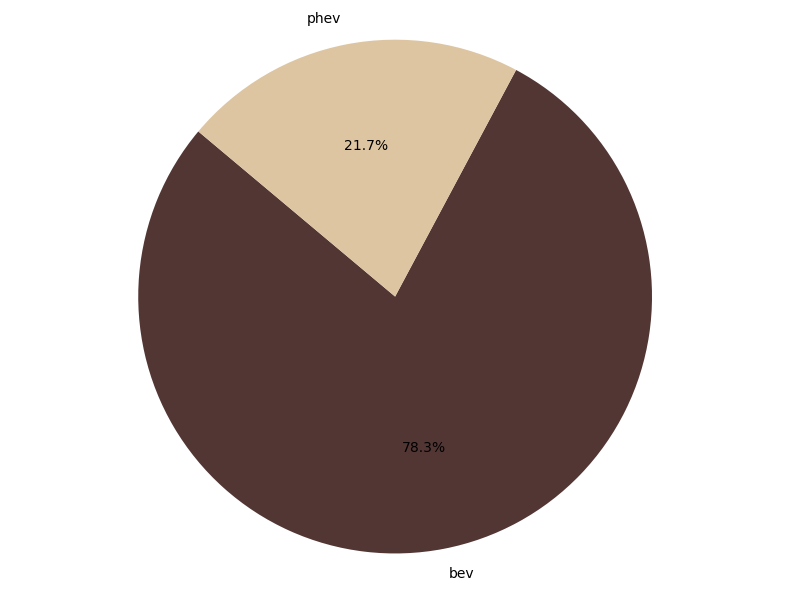

In [194]:
# Создание круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(state_counts.values, labels=state_counts.index, colors=['#523634', '#DDC5A2'],
        autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.tight_layout()
plt.show()

#### Наибольшее предпочтение отдаётся полностью электрическим автомобилям, нежели гибридным. 

In [195]:
# Топ 10 округов по количеству электромобилей
top_counties = df_clean['county'].value_counts().head(10)
top_counties

king         97012
snohomish    22086
pierce       14542
clark        11005
thurston      6779
kitsap        6145
spokane       4856
whatcom       4455
benton        2282
skagit        2028
Name: county, dtype: int64

In [196]:
# Подсчет количества BEV и PHEV в каждом из топ 10 округов
bev_top_counties = df_clean[df_clean['ev_type'] == 'bev'].groupby('county').size().reindex(top_counties.index, fill_value=0)
phev_top_counties = df_clean[df_clean['ev_type'] == 'phev'].groupby('county').size().reindex(top_counties.index, fill_value=0)

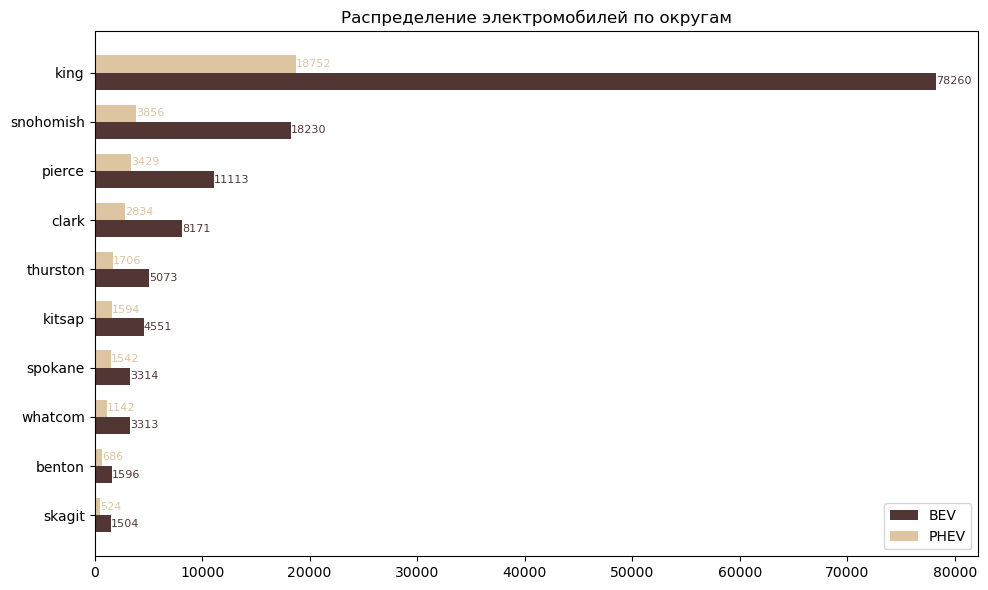

In [197]:
# Сортировка данных по убыванию общего количества автомобилей
top_counties_sorted = top_counties.iloc[::-1]
bev_counts_sorted = bev_top_counties.loc[top_counties_sorted.index]
phev_counts_sorted = phev_top_counties.loc[top_counties_sorted.index]


fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(top_counties_sorted))
bar_height = 0.35

# Создание горизонтальных столбцов для BEV и PHEV
bars1 = plt.barh(index, bev_counts_sorted, bar_height, label='BEV', color='#523634')
bars2 = plt.barh([i + bar_height for i in index], phev_counts_sorted, bar_height, label='PHEV', color='#DDC5A2')

# Вывод значений снаружи столбцов
for i, (bev, phev) in enumerate(zip(bev_counts_sorted, phev_counts_sorted)):
    plt.text(bev + 1, i, str(bev), color='#523634', va='center', fontsize=8)
    plt.text(phev + 1, i + bar_height, str(phev), color='#DDC5A2', va='center', fontsize=8)

# Настройки осей и легенды
plt.title('Распределение электромобилей по округам')
plt.yticks([i + bar_height / 2 for i in index], top_counties_sorted.index)
plt.legend()

plt.tight_layout()
plt.show()

#### На данном графике видно, что электроавтомобиле имеют наибольшую поплуярность в штате King

In [198]:
# Топ 10 городов по количеству электромобилей
top_cities = df_clean['city'].value_counts().head(10)
top_cities

seattle      30873
bellevue      9370
redmond       6747
vancouver     6531
bothell       6151
kirkland      5608
sammamish     5494
renton        5399
olympia       4501
tacoma        3891
Name: city, dtype: int64

In [199]:
# Подсчет количества BEV и PHEV в каждом из топ 10 городов
bev_top_cities = df_clean[df_clean['ev_type'] == 'bev'].groupby('city').size().reindex(top_cities.index, fill_value=0)
phev_top_cities = df_clean[df_clean['ev_type'] == 'phev'].groupby('city').size().reindex(top_cities.index, fill_value=0)

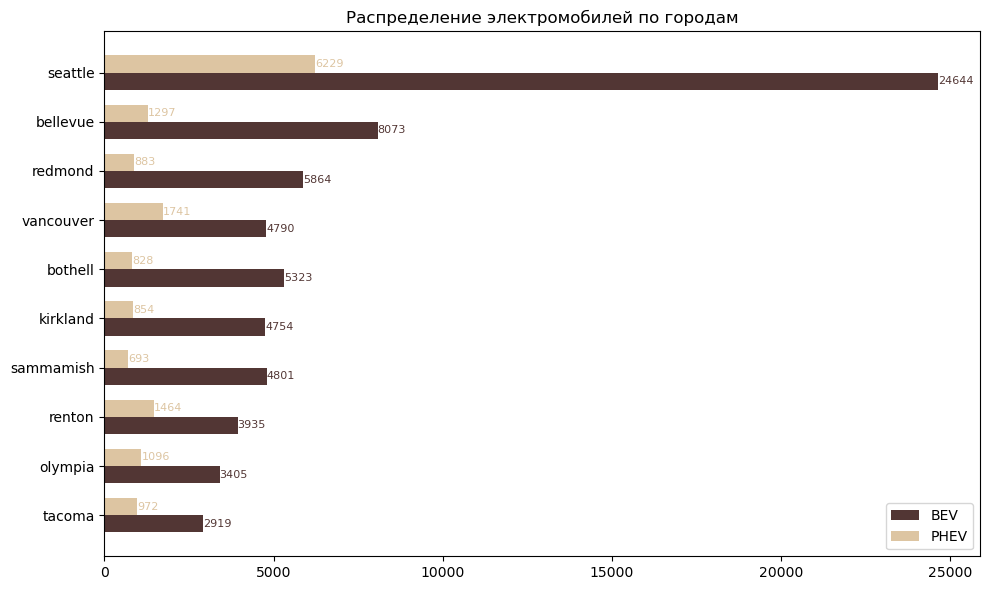

In [200]:
# Сортировка данных по убыванию общего количества автомобилей
top_cities_sorted = top_cities.iloc[::-1]
bev_counts_sorted = bev_top_cities.loc[top_cities_sorted.index]
phev_counts_sorted = phev_top_cities.loc[top_cities_sorted.index]

# Визуализация данных по городам
fig, ax = plt.subplots(figsize=(10, 6))

index = range(len(top_cities_sorted))
bar_height = 0.35

# Создание горизонтальных столбцов для BEV и PHEV
bars1 = plt.barh(index, bev_counts_sorted, bar_height, label='BEV', color='#523634')
bars2 = plt.barh([i + bar_height for i in index], phev_counts_sorted, bar_height, label='PHEV', color='#DDC5A2')

# Вывод значений снаружи столбцов
for i, (bev, phev) in enumerate(zip(bev_counts_sorted, phev_counts_sorted)):
    plt.text(bev + 1, i, str(bev), color='#523634', va='center', fontsize=8)
    plt.text(phev + 1, i + bar_height, str(phev), color='#DDC5A2', va='center', fontsize=8)

# Настройки осей и легенды
plt.title('Распределение электромобилей по городам')
plt.yticks([i + bar_height / 2 for i in index], top_cities_sorted.index)
plt.legend()

plt.tight_layout()
plt.show()

#### Вполне очевидно что наибольшее количество электроавтомобилей будет в центре округа Кинг - городе Сиэтл. На втором месте город Белвью - тоже из округа Кинг.

## 3.1.2 Распределние по моделям авто

In [201]:
# Топ-10 по штату Вашингтон
top_10_state = df_clean['car'].value_counts().head(10)

In [202]:
# Топ-10 по округу King
top_10_king = df_clean[df_clean['county'] == 'king']['car'].value_counts().head(10)

In [203]:
# Топ-10 по городу Seattle 
top_10_seattle = df_clean[df_clean['city'] == 'seattle']['car'].value_counts().head(10)

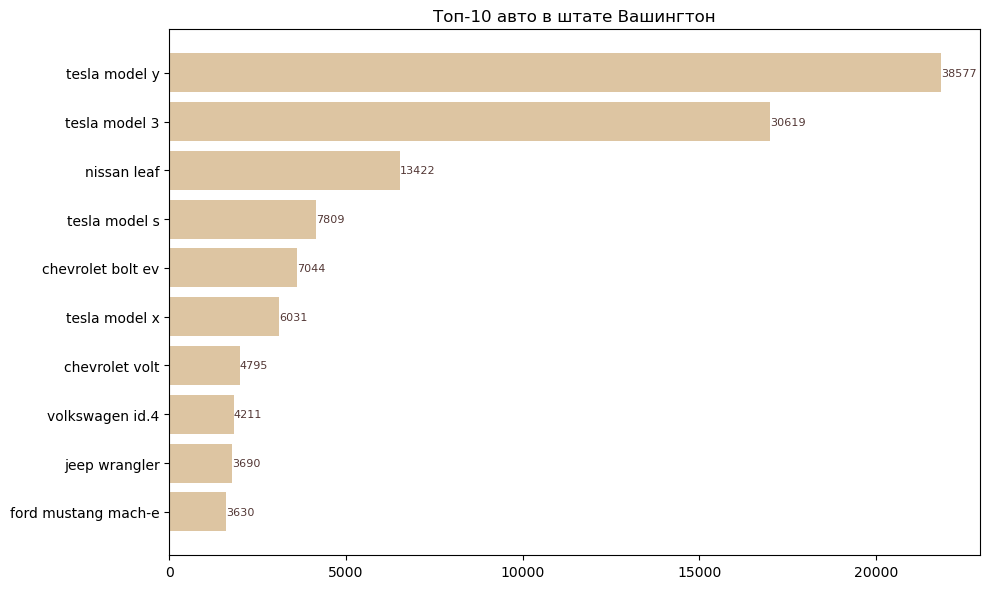

In [204]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = plt.barh(top_10_state.index, top_10_county_king.values, color='#DDC5A2')

# Вывод значений снаружи столбцов
for bar, value in zip(bars, top_10_state.values):
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, str(value), va='center', fontsize=8, color='#523634')

plt.title('Топ-10 авто в штате Вашингтон')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

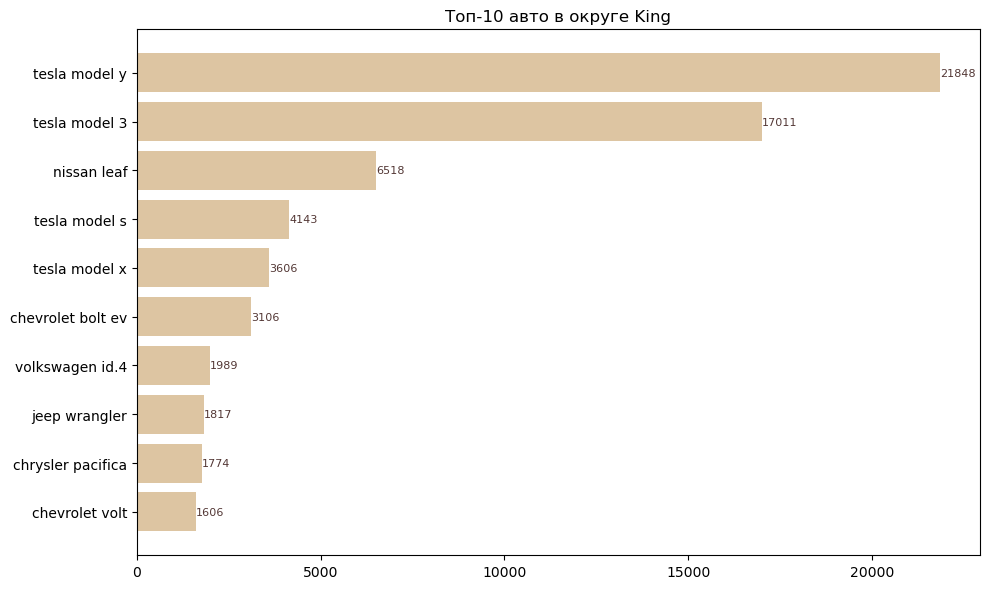

In [205]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = plt.barh(top_10_king.index, top_10_county_king.values, color='#DDC5A2')

# Вывод значений снаружи столбцов
for bar, value in zip(bars, top_10_king.values):
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, str(value), va='center', fontsize=8, color='#523634')

plt.title('Топ-10 авто в округе King')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

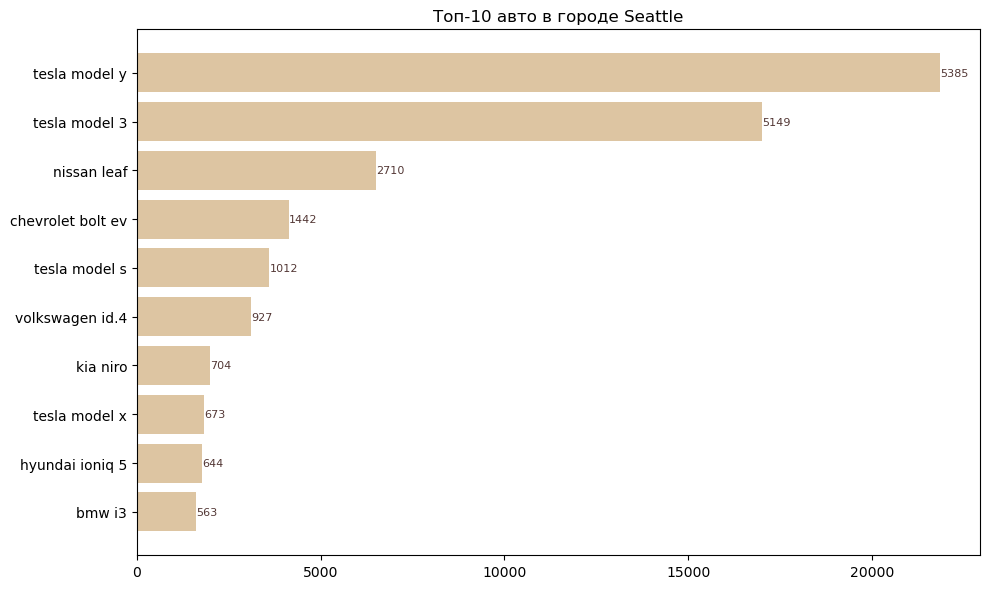

In [206]:
fig, ax = plt.subplots(figsize=(10, 6))

bars = plt.barh(top_10_seattle.index, top_10_county_king.values, color='#DDC5A2')

# Вывод значений снаружи столбцов
for bar, value in zip(bars, top_10_seattle.values):
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, str(value), va='center', fontsize=8, color='#523634')

plt.title('Топ-10 авто в городе Seattle')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

#### В данный раздел анализа был взят полностью штат Вашингтон, самый популярный штат среди электроавтомобилей - Кинг, и так же самый популярный город - Сиэтл. На получившихся графиках можно увидеть, что лидирующие позицию по популярности среди моделей авто занимают Tesla Model Y, Tesla Model 3 и Nissan Leaf.

## 3.2 Анализ пробега электромобилей

In [207]:
bev_avg_range = df_clean[df_clean['ev_type'] == 'bev']['electric_range'].mean()
phev_avg_range = df_clean[df_clean['ev_type'] == 'phev']['electric_range'].mean()
print(f"Средний пробег на одном заряде для электромобилей: {bev_avg_range:.2f}")
print(f"Средний пробег на одном заряде для гибридных авто: {phev_avg_range:.2f}")

Средний пробег на одном заряде для электромобилей: 281.87
Средний пробег на одном заряде для гибридных авто: 43.71


In [208]:
# Выбор данных для определенных моделей
selected_models = ['tesla model y', 'tesla model 3', 'nissan leaf']
filtered_data = df_clean[df_clean['car'].str.lower().isin(selected_models)]

# Расчет среднего electric_range для выбранных моделей
avg_range_by_model = filtered_data.groupby('car')['electric_range'].mean()

print("Средний electric_range для выбранных моделей:")
print(avg_range_by_model)

Средний electric_range для выбранных моделей:
car
nissan leaf      215.0
tesla model 3    322.0
tesla model y    291.0
Name: electric_range, dtype: float64


#### Средний пробег у топ-3 популярных авто очень хорош. У моделей tesla пробег на одном заряде выше чем средний пробег всех электромобилей. У Nissan Leaf пробег на одном заряде чуть меньше среднестатистического, но его популярность может быть обусловлена ценой и его габаритами.

## 3.3 Анализ льгот и субсидий

In [209]:
cafv_eligible_models = df_clean[df_clean['cafv'].str.lower() == 'yes']['car'].value_counts().head(10)

print("Топ-10 моделей автомобилей, удовлетворяющих требованиям CAFV:")
print(cafv_eligible_models)

Топ-10 моделей автомобилей, удовлетворяющих требованиям CAFV:
tesla model 3        13832
nissan leaf          10769
tesla model s         6001
chevrolet volt        4795
chevrolet bolt ev     4463
tesla model x         3324
chrysler pacifica     3261
toyota rav4 prime     2418
tesla model y         2391
bmw x5                1935
Name: car, dtype: int64


In [219]:
# Подсчет количества льготных авто
yes_count = df_clean[df_clean['cafv'] == 'yes'].shape[0]

# Общее количество записей в датасете
total_records = df_clean.shape[0]

percentage_yes = (yes_count / total_records) * 100

print(f"Процент авто, удовлетворяющих субсидиям и льготам: {percentage_yes:.1f}%")

Процент авто, удовлетворяющих субсидиям и льготам: 36.3%


### Снова в топе Tesla Model 3 и Nissan Leaf, на данные авто проще получить льготы и субсидии. Так же, наиболее популярная Tesla Model Y имеет неплохие шансы на льготы и субсидии.

## 4. Выводы

### Рынок электроавтомобилей в штате Вашингтон достаточно обширен. Представлены различные марки и модели авто, но лидером среди всех можно выделить производителя Tesla с моделями Y и 3. Это монополист в сфере электроавтомобилей. Но так же на рынке широко представлен японский Nissan Leaf, что может быть связано с его ценой, надежностью и габаритами.
### Чуть более трети электроавтомобилей в штате имеют льготы и субсидии. Опять же лидером по этому показателю остается Tesla.